In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.corr import auto_correlation_matrix, get_significant_correlations
from utils.tableone import compute_tableone, filter_tableone
from utils.plots import (
    KDEConfig, plot_kde,
    HistConfig, plot_hist,
    DualAxisConfig, plot_dual_axis_trend,
    HeatmapConfig, plot_heatmap
)

PROJECT_PATH = Path('.').absolute().parents[0]
DATA_PATH = Path(PROJECT_PATH, 'raw')

print('Project path: ', PROJECT_PATH)
print('Data path: ', DATA_PATH)

Project path:  /Users/taehyun/project/side-projects/data/dunnhumby
Data path:  /Users/taehyun/project/side-projects/data/dunnhumby/raw


# Exploration for Dunnhumby The-Complete-Journey

## Data Overview

**Data table**
- campaign_table
- transaction_data
- hh_demographic

**Lookup table**
- campaign_desc
- coupon
- coupon_redempt
- product


```
hh_demographic ──┐
                 │
                 ├─→ transaction_data ←─→ product
                 │         ↓
campaign_table ──┘         ↓
      ↓              causal_data
campaign_desc
      ↓
    coupon ←──→ coupon_redempt
```

In [2]:
list(map(lambda pth: pth.name, DATA_PATH.rglob('*.csv')))

['hh_demographic.csv',
 'causal_data.csv',
 'coupon.csv',
 'campaign_table.csv',
 'coupon_redempt.csv',
 'product.csv',
 'campaign_desc.csv',
 'transaction_data.csv']

## Table of Contents

1. [Household Demographics](#1.-Household-Demographics)
   - 1.1 Data Loading & Overview
   - 1.2 Distributions
   - 1.3 Correlation Analysis
2. [Transaction Patterns](#2.-Transaction-Patterns)
   - 2.1 Data Loading & Cleaning
   - 2.2 Household-level Analysis
   - 2.3 Store-level Analysis
   - 2.4 Basket-level Analysis
   - 2.5 Time Trends
   - 2.6 Discount Analysis
   - 2.7 Segment Analysis & Demographics
     - 2.7.1 By Value (High vs Low Spenders)
     - 2.7.2 By Frequency (Frequent vs Occasional)
     - 2.7.3 By Discount Sensitivity
     - 2.7.4 Cross-Segment Analysis
       - Value × Frequency
       - Value × Discount Sensitivity
       - Frequency × Discount Sensitivity

## 1. Household Demographics (`hh_demographic`)

### 1.1 Data Loading & Overview

In [3]:
column_mapping = {
    'classification_1': 'AGE_GRP',
    'classification_2': 'MARITAL',
    'classification_3': 'INCOME_GRP',
    'classification_4': 'HOUSEHOLD_SIZE',
    'classification_5': 'HOUSEHOLD_COMPOSITION',
    'HOMEOWNER_DESC': 'HOMEOWNER_DESC',
    'KID_CATEGORY_DESC': 'KID_CATEGORY_DESC',
}

df_demo = pd.read_csv(
    DATA_PATH / 'hh_demographic.csv'
).rename(columns=column_mapping)
                                                                                                                        
df_demo.head()                                                                                              

,AGE_GRP,MARITAL,INCOME_GRP,HOMEOWNER_DESC,HOUSEHOLD_COMPOSITION,HOUSEHOLD_SIZE,KID_CATEGORY_DESC,household_key
0,Age Group6,X,Level4,Homeowner,Group5,2,None/Unknown,1
1,Age Group4,X,Level5,Homeowner,Group5,2,None/Unknown,7
2,Age Group2,Y,Level3,Unknown,Group4,3,1,8
3,Age Group2,Y,Level6,Homeowner,Group4,4,2,13
4,Age Group4,Z,Level5,Homeowner,Group3,1,None/Unknown,16


In [4]:
len(df_demo)

801

In [5]:
df_demo.isnull().sum().to_frame().T

,AGE_GRP,MARITAL,INCOME_GRP,HOMEOWNER_DESC,HOUSEHOLD_COMPOSITION,HOUSEHOLD_SIZE,KID_CATEGORY_DESC,household_key
0,0,0,0,0,0,0,0,0


### 1.2 Distributions

In [6]:
fn_cat_grp_cnt = lambda col: (
    df_demo.groupby(by=col)['household_key'].count().to_frame().assign(**{
        'count': lambda elem: elem['household_key'],
        'proportion': lambda elem: elem['household_key'] / len(df_demo)
    }).drop('household_key', axis=1)
)

for col in df_demo.columns[:-1]:
    print('=====' * 5, col)
    print(fn_cat_grp_cnt(col).round(3).to_markdown())
    print(' \n')

========================= AGE_GRP
| AGE_GRP    |   count |   proportion |
|:-----------|--------:|-------------:|
| Age Group1 |      46 |        0.057 |
| Age Group2 |     142 |        0.177 |
| Age Group3 |     194 |        0.242 |
| Age Group4 |     288 |        0.36  |
| Age Group5 |      59 |        0.074 |
| Age Group6 |      72 |        0.09  |
 

========================= MARITAL
| MARITAL   |   count |   proportion |
|:----------|--------:|-------------:|
| X         |     340 |        0.424 |
| Y         |     344 |        0.429 |
| Z         |     117 |        0.146 |
 

========================= INCOME_GRP
| INCOME_GRP   |   count |   proportion |
|:-------------|--------:|-------------:|
| Level1       |      61 |        0.076 |
| Level10      |      11 |        0.014 |
| Level11      |       5 |        0.006 |
| Level12      |      11 |        0.014 |
| Level2       |      74 |        0.092 |
| Level3       |      77 |        0.096 |
| Level4       |     172 |        0.21

### 1.3 Correlation Analysis

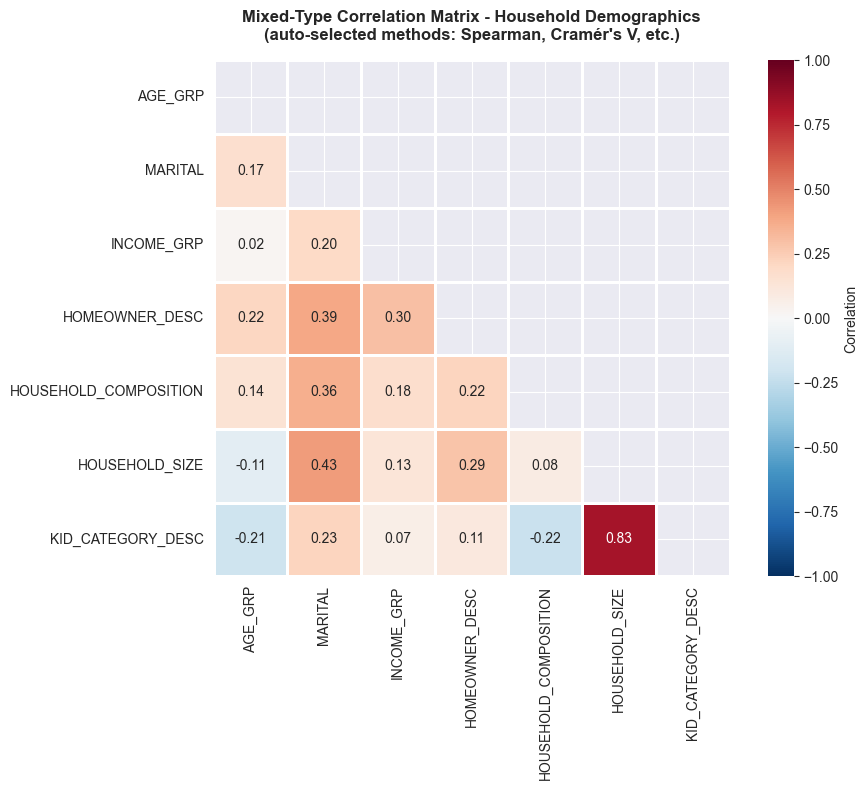


CORRELATION METHODS USED
|                       | AGE_GRP   | MARITAL   | INCOME_GRP   | HOMEOWNER_DESC   | HOUSEHOLD_COMPOSITION   | HOUSEHOLD_SIZE   | KID_CATEGORY_DESC   |
|:----------------------|:----------|:----------|:-------------|:-----------------|:------------------------|:-----------------|:--------------------|
| AGE_GRP               | -         | cramers_v | spearman     | spearman         | spearman                | spearman         | spearman            |
| MARITAL               | cramers_v | -         | cramers_v    | cramers_v        | cramers_v               | cramers_v        | cramers_v           |
| INCOME_GRP            | spearman  | cramers_v | -            | spearman         | spearman                | spearman         | spearman            |
| HOMEOWNER_DESC        | spearman  | cramers_v | spearman     | -                | spearman                | spearman         | spearman            |
| HOUSEHOLD_COMPOSITION | spearman  | cramers_v | spearman     | spe

In [7]:
ordinal_orders = {
    'AGE_GRP': ['Age Group1', 'Age Group2', 'Age Group3', 'Age Group4', 'Age Group5', 'Age Group6'],
    'INCOME_GRP': [f'Level{i}' for i in range(1, 13)],
    'HOMEOWNER_DESC': ['Renter', 'Probable Renter', 'Unknown', 'Probable Owner', 'Homeowner'],
    'HOUSEHOLD_COMPOSITION': [f'Group{i}' for i in range(1, 7)],
    'HOUSEHOLD_SIZE': ['1', '2', '3', '4', '5+'],
    'KID_CATEGORY_DESC': ['None/Unknown', '1', '2', '3+']
}


type_overrides = {
    'AGE_GRP': 'ordinal',
    'MARITAL': 'categorical',
    'INCOME_GRP': 'ordinal',
    'HOMEOWNER_DESC': 'ordinal',
    'HOUSEHOLD_COMPOSITION': 'ordinal',
    'HOUSEHOLD_SIZE': 'ordinal',
    'KID_CATEGORY_DESC': 'ordinal'
}

demo_cols = ['AGE_GRP', 'MARITAL', 'INCOME_GRP', 'HOMEOWNER_DESC', 'HOUSEHOLD_COMPOSITION', 'HOUSEHOLD_SIZE', 'KID_CATEGORY_DESC']
corr_df = auto_correlation_matrix(
    df_demo,
    columns=demo_cols,
    ordinal_overrides=ordinal_orders,
    type_overrides=type_overrides
)

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_df, dtype=bool))
sns.heatmap(
    corr_df, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
    center=0, vmin=-1, vmax=1, square=True, linewidths=1,
    cbar_kws={'label': 'Correlation'}, ax=ax
)
plt.title('Mixed-Type Correlation Matrix - Household Demographics\n(auto-selected methods: Spearman, Cramér\'s V, etc.)', 
          fontsize=12, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CORRELATION METHODS USED")
print("="*60)
print(corr_df.attrs['methods'].to_markdown())

sig_corrs = get_significant_correlations(corr_df, threshold=0.3, p_threshold=0.05)
print("\n" + "="*60)
print("SIGNIFICANT CORRELATIONS (|r| > 0.3 and p < 0.05)")
print("="*60)
if len(sig_corrs) > 0:
    print(sig_corrs.to_markdown(index=False))
else:
    print("No significant correlations found.")

**Summary: Household Demographics**
- **801 households** with demographic data (32% of total 2,500)
- **No missing values** across all demographic variables
- **Key distributions:**
  - `AGE_GRP`: Group4 dominant (36%), Group3 second (24%)
  - `INCOME_GRP`: Level4-5 most common (46%), long tail in higher levels
  - `HOMEOWNER_DESC`: 63% Homeowners, 29% Unknown
  - `HOUSEHOLD_SIZE`: 1-2 person households dominate (72%)
  - `KID_CATEGORY_DESC`: 70% None/Unknown
- **Significant correlations (|r| > 0.3):**
  - `HOUSEHOLD_SIZE` ↔ `KID_CATEGORY_DESC`: 0.84 (strong)
  - `MARITAL` ↔ `HOUSEHOLD_SIZE`: 0.42
  - `MARITAL` ↔ `HOMEOWNER_DESC`: 0.38

## 2. Transaction Patterns

### 2.1 Data Loading & Cleaning

In [8]:
df_trans = pd.read_csv(
    DATA_PATH / 'transaction_data.csv'
)

df_trans.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [9]:
df_trans[['DAY', 'WEEK_NO', 'QUANTITY', 'SALES_VALUE', 'RETAIL_DISC', 'TRANS_TIME', 'COUPON_DISC', 'COUPON_MATCH_DISC']].describe().round(3)

# outliers.. 
# 1. Quantity == 0
# 2. RETAIL_DISC > 0

,DAY,WEEK_NO,QUANTITY,SALES_VALUE,RETAIL_DISC,TRANS_TIME,COUPON_DISC,COUPON_MATCH_DISC
count,2595732.000,2595732.000,2595732.000,2595732.000,2595732.000,2595732.000,2595732.000,2595732.000
mean,388.756,56.221,100.429,3.104,-0.539,1561.586,-0.016,-0.003
std,189.721,27.102,1153.436,4.182,1.249,399.838,0.217,0.040
min,1.000,1.000,0.000,0.000,-180.000,0.000,-55.930,-7.700
25%,229.000,33.000,1.000,1.290,-0.690,1308.000,0.000,0.000
50%,390.000,56.000,1.000,2.000,-0.010,1613.000,0.000,0.000
75%,553.000,80.000,1.000,3.490,0.000,1843.000,0.000,0.000
max,711.000,102.000,89638.000,840.000,3.990,2359.000,0.000,0.000


In [10]:
df_trans.isnull().sum().to_frame().T

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
df_trans[df_trans['QUANTITY'] == 0].head() # outliers

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
97,744,26985165432,1,5978648,0,0.0,31582,0.0,1119,1,0.0,0.0
128,1287,26985336468,1,5978648,0,0.0,304,0.0,1351,1,0.0,0.0
249,2305,26996870743,2,5978656,0,0.0,414,0.0,1300,1,-1.0,0.0
293,271,26997082949,2,5978656,0,0.0,329,0.0,1719,1,-2.0,0.0
694,315,27008952267,3,957951,0,0.0,327,0.0,1707,1,0.0,0.0


In [12]:
df_trans[df_trans['RETAIL_DISC'] > 0].head() # outliers

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
968972,1306,31624096856,310,990941,0,0.01,340,1.000000e-02,2253,45,0.0,0.0
1001608,1306,31735306143,318,7409789,0,0.00,381,2.220446e-16,1232,46,0.0,0.0
1023085,1321,31803641901,323,1051069,0,0.00,364,5.551115e-17,1931,47,0.0,0.0
1023086,1321,31803641901,323,1055863,0,0.00,364,5.551115e-17,1931,47,0.0,0.0
1067337,37,31944616637,334,8090539,0,0.00,381,2.220446e-16,1434,48,0.0,0.0


In [13]:
# delete outliers
df_trans = df_trans[(df_trans['QUANTITY'] > 0) & (df_trans['RETAIL_DISC'] <= 0)]


# negate discount columns (stored as negative in raw data)
df_trans = df_trans.assign(**{
    'COUPON_MATCH_DISC': -df_trans['COUPON_MATCH_DISC'],
    'COUPON_DISC': -df_trans['COUPON_DISC'],
    'RETAIL_DISC': -df_trans['RETAIL_DISC']
})


# derived columns (formulas adjusted for negated discount values)
# Reference: dunnhumby User Guide p.3
# - SHELF_PRICE: original shelf price before any discount (adds back retail_disc + coupon_match_disc)
# - UNIT_PRICE: price per unit charged to customer (sales_value / quantity)
# - ACTUAL_SPENT: what customer actually paid (subtracts coupon_disc from sales_value)
df_trans = df_trans.assign(**{
    'SHELF_PRICE': lambda x: (x['SALES_VALUE'] + x['RETAIL_DISC'] + x['COUPON_MATCH_DISC']) / x['QUANTITY'],
    'UNIT_PRICE': lambda x: x['SALES_VALUE'] / x['QUANTITY'],
    'ACTUAL_SPENT': lambda x: x['SALES_VALUE'] - x['COUPON_DISC']
})

df_trans.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,SHELF_PRICE,UNIT_PRICE,ACTUAL_SPENT
0,2375,26984851472,1,1004906,1,1.39,364,0.60,1631,1,-0.0,-0.0,1.99,1.39,1.39
1,2375,26984851472,1,1033142,1,0.82,364,-0.00,1631,1,-0.0,-0.0,0.82,0.82,0.82
2,2375,26984851472,1,1036325,1,0.99,364,0.30,1631,1,-0.0,-0.0,1.29,0.99,0.99
3,2375,26984851472,1,1082185,1,1.21,364,-0.00,1631,1,-0.0,-0.0,1.21,1.21,1.21
4,2375,26984851472,1,8160430,1,1.50,364,0.39,1631,1,-0.0,-0.0,1.89,1.50,1.50


In [14]:
print('# of households: ', len(df_trans.household_key.drop_duplicates()))
print('# of stores: ', len(df_trans.STORE_ID.drop_duplicates()))
print('# of transactions: ', len(df_trans))
print('# of baskets: ', len(df_trans.BASKET_ID.drop_duplicates()))
print('# of product: ', len(df_trans.PRODUCT_ID.drop_duplicates()))

# of households:  2500
# of stores:  582
# of transactions:  2581260
# of baskets:  275889
# of product:  92015


### 2.2 Household-level Analysis

In [15]:
df_trans_hh = df_trans.groupby('household_key').agg(**{
    'transaction': ('household_key', 'size'),
    'basket_id_count': ('BASKET_ID', 'nunique'),
    'product_id_count': ('PRODUCT_ID', 'nunique'),
    'coupon_disc': ('COUPON_DISC', 'sum'),
    'total_spent': ('ACTUAL_SPENT', 'sum')
})
                                 
df_trans_hh.describe().T

,count,mean,std,min,25%,50%,75%,max
transaction,2500.0,1032.504000,993.279847,4.00,321.0000,730.000,1445.5000,6775.00
basket_id_count,2500.0,110.355600,115.433111,1.00,38.0000,78.000,142.0000,1298.00
product_id_count,2500.0,558.067600,434.335856,4.00,230.0000,453.000,784.0000,3144.00
coupon_disc,2500.0,12.913204,32.478275,0.00,0.0000,2.500,10.4125,412.68
total_spent,2500.0,3210.057856,3335.156106,8.17,966.4775,2151.765,4397.4025,38289.21


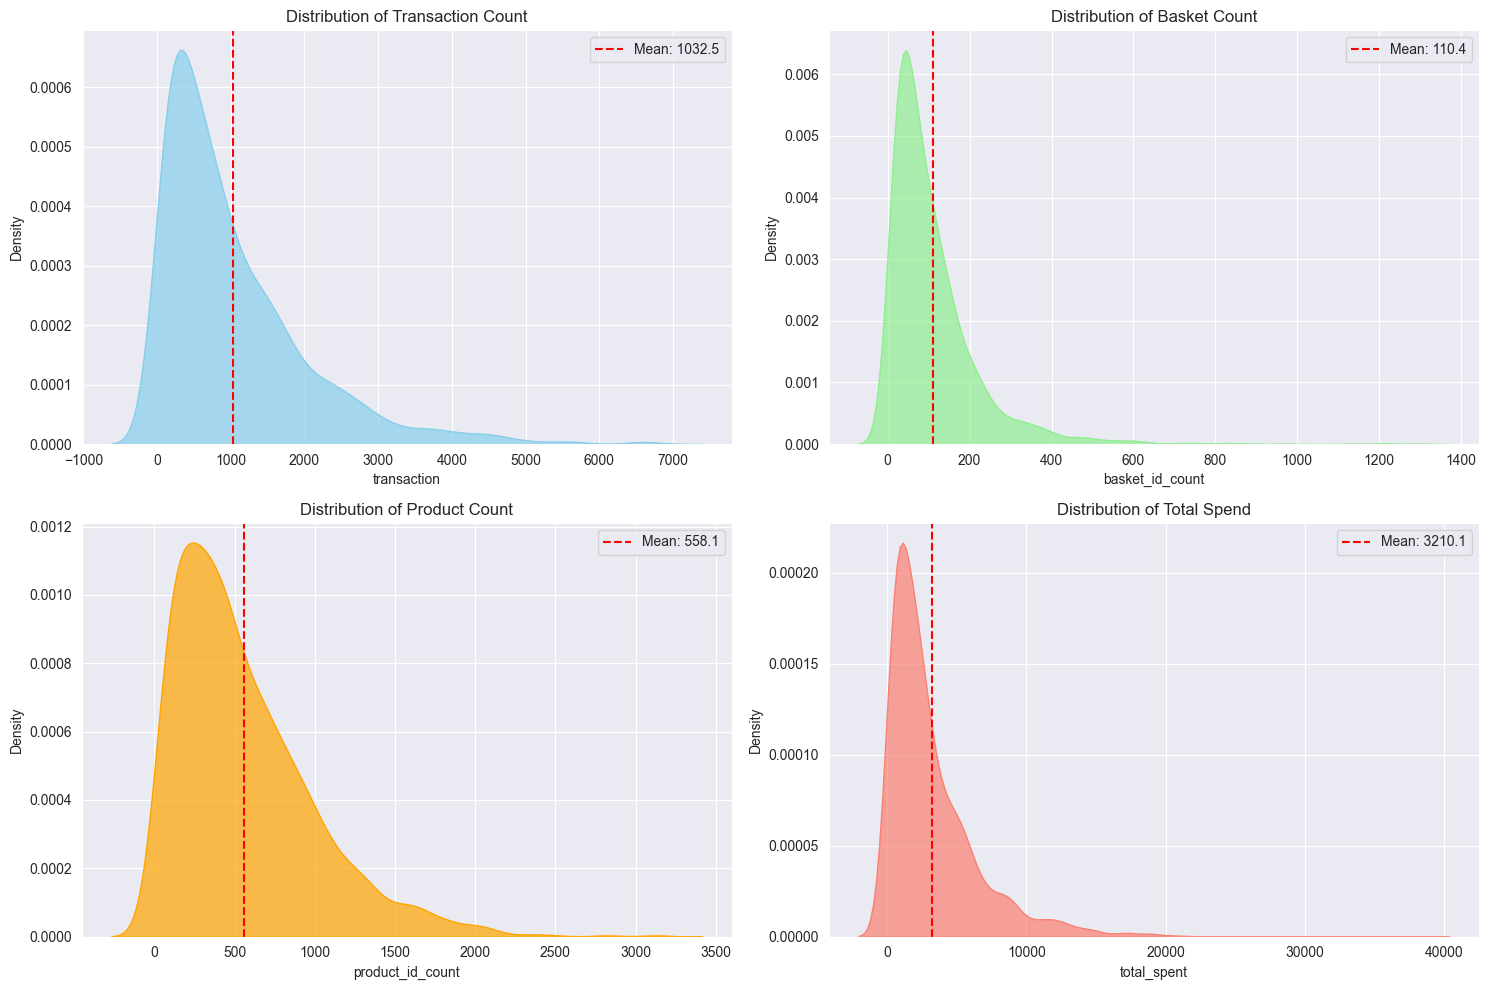

In [16]:
# Household-level distributions using utils/plots.py
kde_configs = [
    KDEConfig('transaction', 'Transaction Count', 'skyblue'),
    KDEConfig('basket_id_count', 'Basket Count', 'lightgreen'),
    KDEConfig('product_id_count', 'Product Count', 'orange'),
    KDEConfig('total_spent', 'Total Spend', 'salmon'),
]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
list(map(lambda args: plot_kde(*args), zip(axes.flat, [df_trans_hh] * 4, kde_configs)))
plt.tight_layout()
plt.show()

**Household-level summary:**

- Avg **1,033 transactions**, **110 baskets**, **$3,210 total spent** per household

- High variance: std ≈ mean for most metrics (right-skewed distributions)

- Heavy users: top households have 6,775 transactions, $38K spent

### 2.3 Store-level Analysis

In [17]:
# Store-level 집계
df_trans_store = df_trans.groupby('STORE_ID').agg(**{
    'transaction': ('STORE_ID', 'size'),
    'basket_count': ('BASKET_ID', 'nunique'),
    'customer_count': ('household_key', 'nunique'),
    'total_sales': ('SALES_VALUE', 'sum'),
    'avg_basket_value': ('SALES_VALUE', 'mean')
}).assign(**{
    'sales_per_customer': lambda x: x['total_sales'] / x['customer_count'],
    'baskets_per_customer': lambda x: x['basket_count'] / x['customer_count']
})

print("="*60)
print("STORE-LEVEL METRICS (n=582 stores)")
print("="*60)
print(df_trans_store.describe().round(2).to_markdown())

# Top/Bottom stores
print("\n" + "="*60)
print("TOP 10 STORES BY TOTAL SALES")
print("="*60)
print(df_trans_store.nlargest(10, 'total_sales')[['transaction', 'customer_count', 'total_sales', 'sales_per_customer']].to_markdown())

STORE-LEVEL METRICS (n=582 stores)
|       |   transaction |   basket_count |   customer_count |   total_sales |   avg_basket_value |   sales_per_customer |   baskets_per_customer |
|:------|--------------:|---------------:|-----------------:|--------------:|-------------------:|---------------------:|-----------------------:|
| count |        582    |         582    |           582    |        582    |             582    |               582    |                 582    |
| mean  |       4435.15 |         474.04 |            23.46 |      13844.4  |               4.77 |               231.74 |                   8.31 |
| std   |      10217.1  |        1088.9  |            48.76 |      32845    |               6.47 |               425.23 |                  12.9  |
| min   |          1    |           1    |             1    |          0    |               0    |                 0    |                   1    |
| 25%   |          7    |           1    |             1    |         27.97 |      

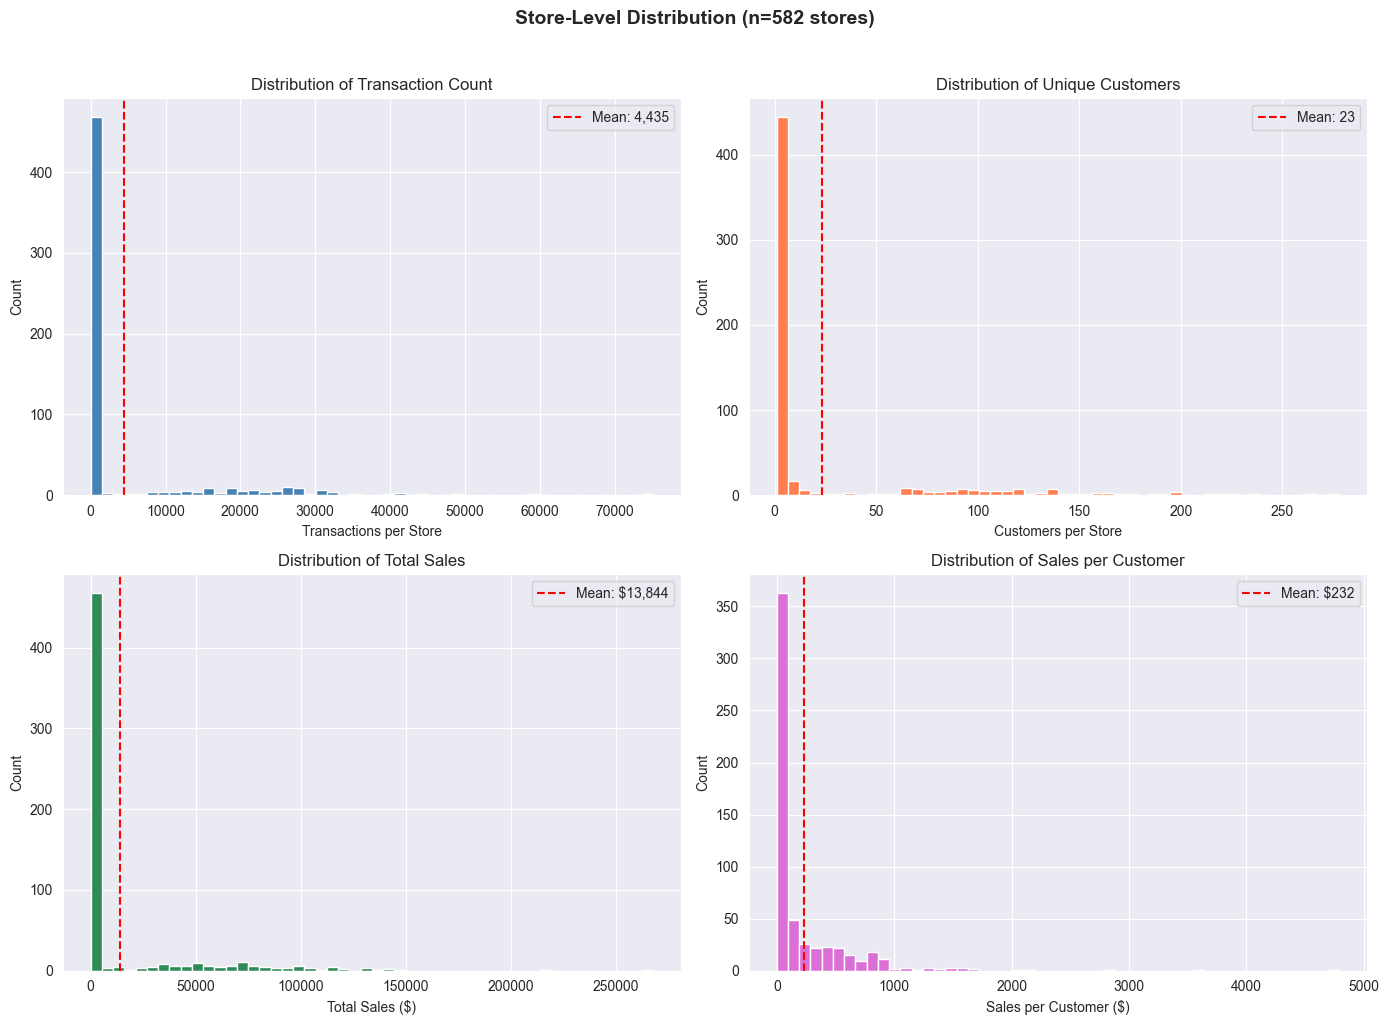


Store Concentration: Top 70 stores (12.0%) account for 80% of total sales


In [18]:
# Store distribution visualization using utils/plots.py
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

store_hist_configs = [
    HistConfig('transaction', 'Transaction Count', 'Transactions per Store', 'steelblue', '{:,.0f}'),
    HistConfig('customer_count', 'Unique Customers', 'Customers per Store', 'coral', '{:,.0f}'),
    HistConfig('total_sales', 'Total Sales', 'Total Sales ($)', 'seagreen', '${:,.0f}'),
    HistConfig('sales_per_customer', 'Sales per Customer', 'Sales per Customer ($)', 'orchid', '${:,.0f}'),
]

list(map(lambda args: plot_hist(*args), zip(axes.flat, [df_trans_store]*4, store_hist_configs)))
plt.suptitle('Store-Level Distribution (n=582 stores)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Store concentration (Pareto)
store_sales_sorted = df_trans_store['total_sales'].sort_values(ascending=False)
store_cumsum = store_sales_sorted.cumsum() / store_sales_sorted.sum()

top_20_pct = (store_cumsum <= 0.8).sum()
print(f"\nStore Concentration: Top {top_20_pct} stores ({top_20_pct/len(df_trans_store)*100:.1f}%) account for 80% of total sales")

**Store-level summary:**
- **582 stores** with highly skewed distribution

- Median store: 30 transactions, 2 customers, $101 sales

- **Pareto effect**: Top 26 stores (4.5%) account for 80% of total sales

- Top store: $267K sales, 264 customers

### 2.4 Basket-level Analysis

In [19]:
# Basket-level aggregation
df_trans_basket = df_trans.groupby('BASKET_ID').agg(**{
    'household_key': ('household_key', 'first'),
    'store_id': ('STORE_ID', 'first'),
    'day': ('DAY', 'first'),
    'items': ('BASKET_ID', 'size'),
    'unique_products': ('PRODUCT_ID', 'nunique'),
    'total_value': ('SALES_VALUE', 'sum'),
    'total_quantity': ('QUANTITY', 'sum'),
}).assign(**{
    'avg_item_price': lambda x: x['total_value'] / x['items'],
})

print("="*60)
print("BASKET-LEVEL METRICS (n=275,889 baskets)")
print("="*60)
print(df_trans_basket[['items', 'unique_products', 'total_value', 'total_quantity', 'avg_item_price']].describe().round(2).to_markdown())

BASKET-LEVEL METRICS (n=275,889 baskets)
|       |     items |   unique_products |   total_value |   total_quantity |   avg_item_price |
|:------|----------:|------------------:|--------------:|-----------------:|-----------------:|
| count | 275889    |         275889    |     275889    |        275889    |        275889    |
| mean  |      9.36 |              9.36 |         29.21 |           944.89 |             5.29 |
| std   |     12.24 |             12.24 |         36.11 |          3423.83 |             8.38 |
| min   |      1    |              1    |          0    |             1    |             0    |
| 25%   |      2    |              2    |          6.98 |             3    |             1.99 |
| 50%   |      5    |              5    |         17.15 |             8    |             2.78 |
| 75%   |     12    |             12    |         36.35 |            22    |             4.17 |
| max   |    168    |            168    |        961.49 |         89638    |           499.99 |

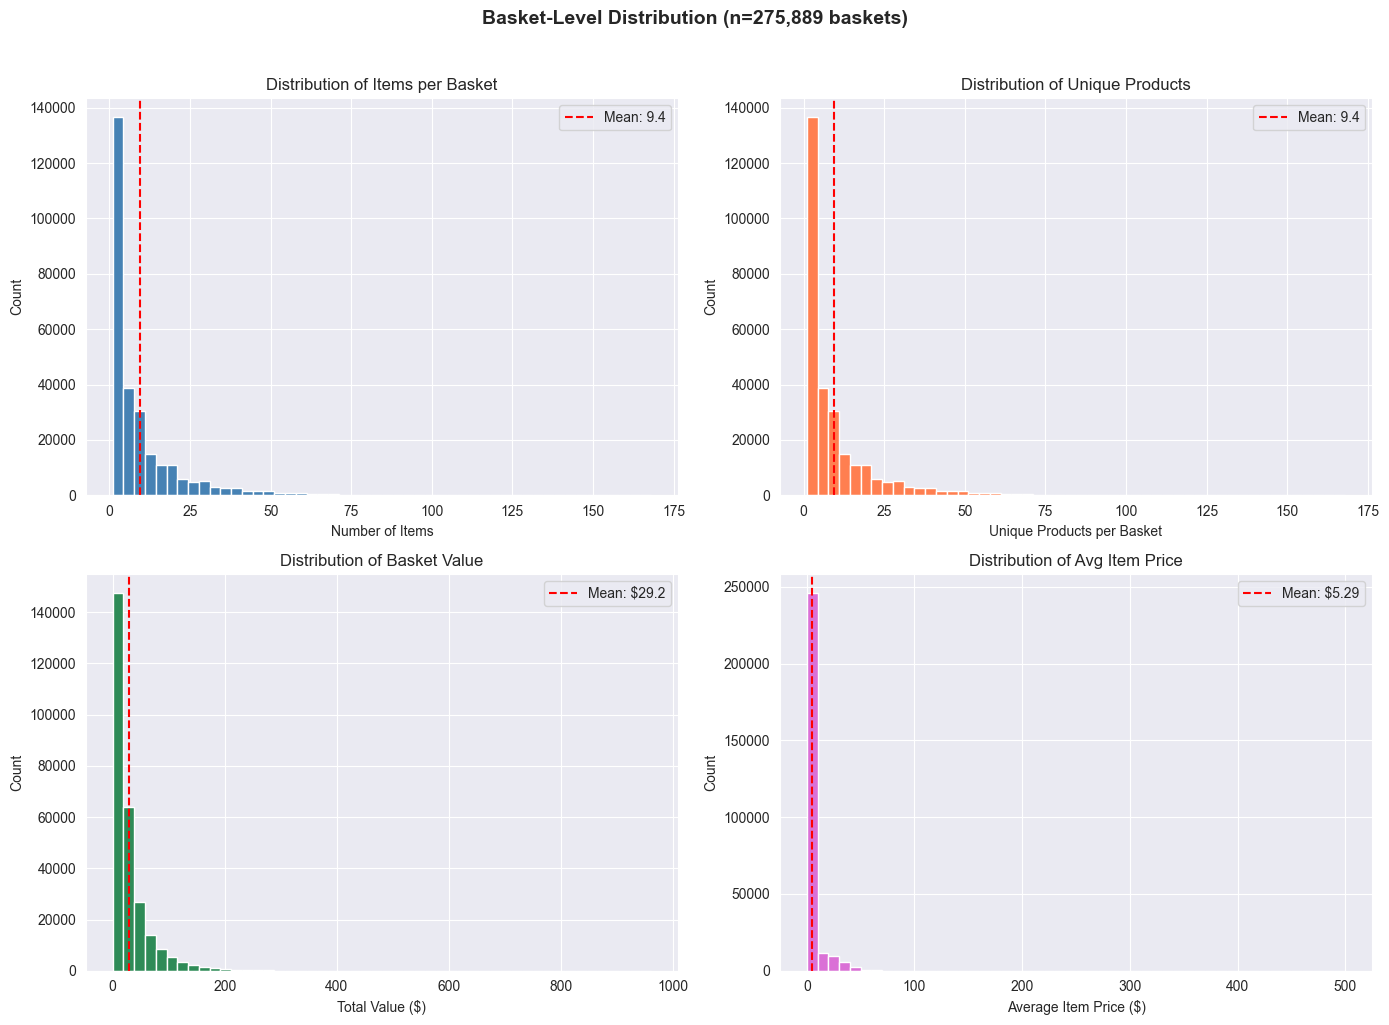


BASKET SIZE DISTRIBUTION
| items   | Proportion   |
|:--------|:-------------|
| 1-5     | 55.0%        |
| 6-10    | 17.2%        |
| 11-20   | 14.8%        |
| 21-50   | 11.2%        |
| 50+     | 1.7%         |


In [20]:
# Basket distribution visualization using utils/plots.py
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

basket_hist_configs = [
    HistConfig('items', 'Items per Basket', 'Number of Items', 'steelblue', '{:.1f}'),
    HistConfig('unique_products', 'Unique Products', 'Unique Products per Basket', 'coral', '{:.1f}'),
    HistConfig('total_value', 'Basket Value', 'Total Value ($)', 'seagreen', '${:.1f}'),
    HistConfig('avg_item_price', 'Avg Item Price', 'Average Item Price ($)', 'orchid', '${:.2f}'),
]

list(map(lambda args: plot_hist(*args), zip(axes.flat, [df_trans_basket]*4, basket_hist_configs)))
plt.suptitle('Basket-Level Distribution (n=275,889 baskets)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Basket size distribution summary
print("\n" + "="*60)
print("BASKET SIZE DISTRIBUTION")
print("="*60)
basket_size_bins = pd.cut(df_trans_basket['items'], bins=[0, 5, 10, 20, 50, np.inf], labels=['1-5', '6-10', '11-20', '21-50', '50+'])
print(basket_size_bins.value_counts(normalize=True).sort_index().apply(lambda x: f"{x:.1%}").to_frame('Proportion').to_markdown())

**Basket-level summary:**

- **275,889 baskets** total

- Avg **9.4 items**, **$29.21 value** per basket

- Basket size distribution: 54% have 1-5 items, 22% have 6-10 items

- Avg item price: $5.29 (median $2.78)

### 2.5 Time Trends

|                  |      1 |      2 |       3 |       4 |      5 |       6 |       7 |       8 |       9 |      10 |
|:-----------------|-------:|-------:|--------:|--------:|-------:|--------:|--------:|--------:|--------:|--------:|
| transaction      | 236    | 135    |  523    |  674    | 306    |  334    |  461    |  433    |  362    |  487    |
| basket_id_count  |  14    |  13    |   44    |   44    |  24    |   36    |   34    |   43    |   39    |   51    |
| product_id_count | 225    | 131    |  470    |  614    | 290    |  313    |  436    |  391    |  343    |  455    |
| total_spend      | 549.31 | 458.91 | 1560.37 | 1785.64 | 856.93 | 1008.15 | 1271.29 | 1203.85 | 1050.95 | 1714.38 |


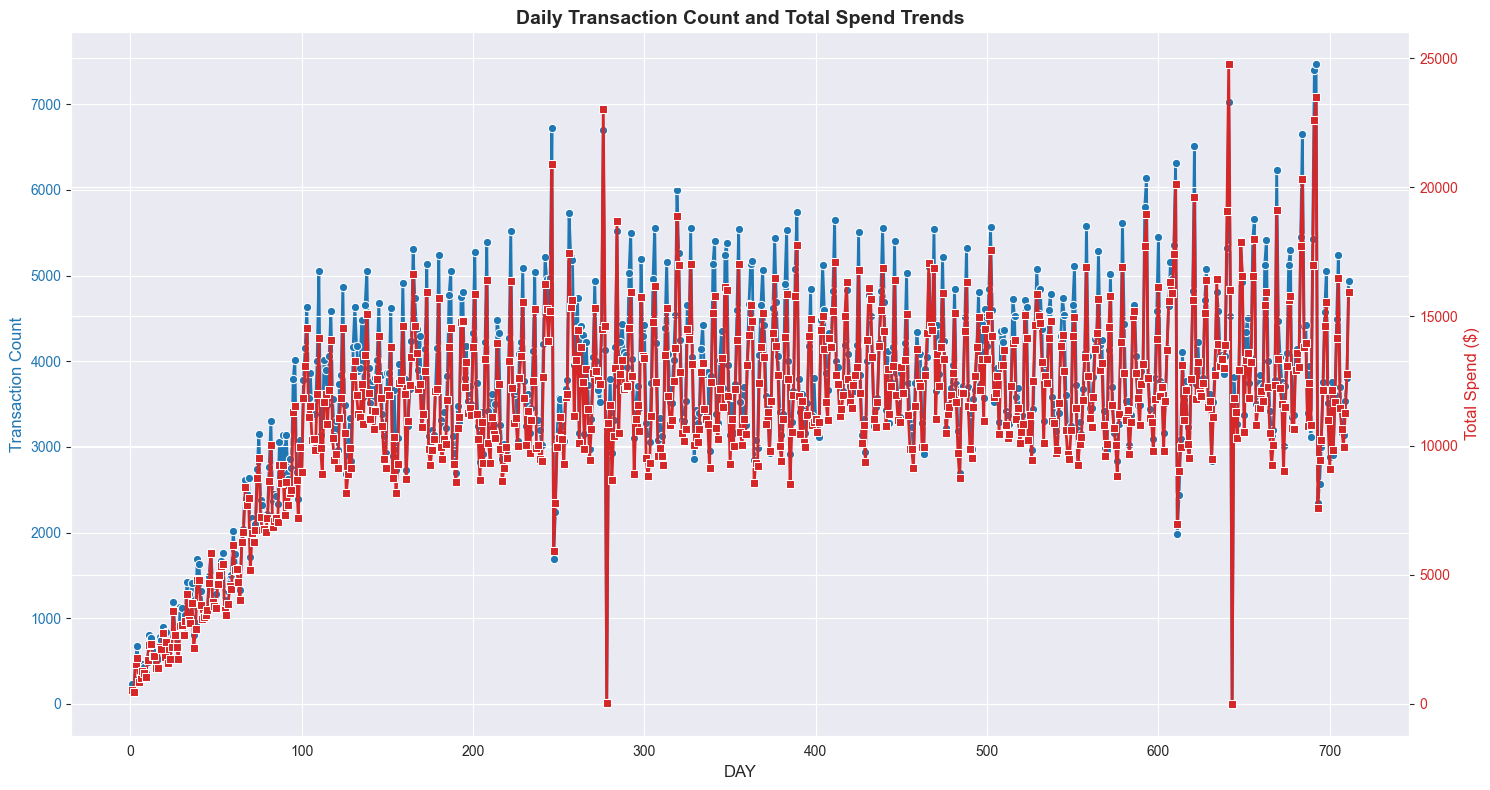

In [21]:
# Time trend aggregation and dual-axis plot using utils/plots.py

def agg_trans_by_period(df: pd.DataFrame, period_col: str) -> pd.DataFrame:
    return df.groupby(period_col).agg(**{
        'transaction': ('household_key', 'size'),
        'basket_id_count': ('BASKET_ID', 'nunique'),
        'product_id_count': ('PRODUCT_ID', 'nunique'),
        'total_spend': ('SALES_VALUE', 'sum')
    })

# Daily aggregation and plot
df_trans_day = agg_trans_by_period(df_trans, 'DAY')

print(df_trans_day[:10].T.to_markdown())
config = DualAxisConfig(
    x_col='DAY',
    left_col='transaction',
    right_col='total_spend',
    title='Daily Transaction Count and Total Spend Trends',
    left_label='Transaction Count',
    right_label='Total Spend ($)'
)
fig, ax1, ax2 = plot_dual_axis_trend(df_trans_day, config)
plt.show()

|                  |       1 |       2 |       3 |     4 |       5 |       6 |     7 |       8 |       9 |      10 |
|:-----------------|--------:|--------:|--------:|------:|--------:|--------:|------:|--------:|--------:|--------:|
| transaction      | 1874    |  3655   |  4775   |  5355 |  7138   |  8841   |  8946 | 10375   | 10534   | 13459   |
| basket_id_count  |  139    |   321   |   480   |   543 |   754   |   855   |   994 |  1083   |  1204   |  1546   |
| product_id_count | 1540    |  2728   |  3294   |  3685 |  4543   |  5410   |  5386 |  5992   |  5969   |  6993   |
| total_spend      | 5211.16 | 10821.4 | 13498.1 | 15966 | 20139.8 | 24923.9 | 28074 | 31793.8 | 31244.2 | 42994.4 |


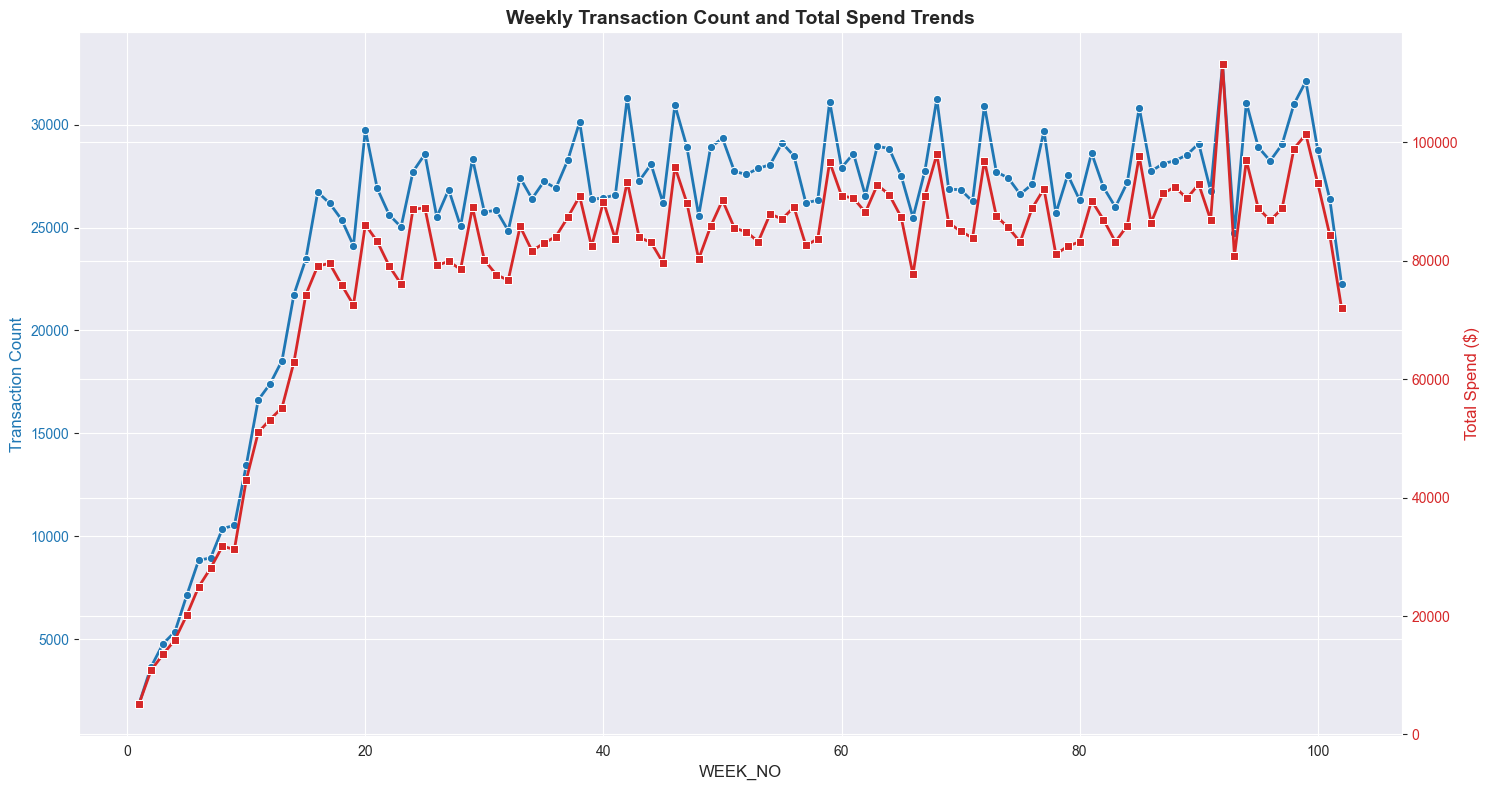

In [22]:
# Weekly aggregation and plot using utils/plots.py
df_trans_week = agg_trans_by_period(df_trans, 'WEEK_NO')

config = DualAxisConfig(
    x_col='WEEK_NO',
    left_col='transaction',
    right_col='total_spend',
    title='Weekly Transaction Count and Total Spend Trends',
    left_label='Transaction Count',
    right_label='Total Spend ($)'
)
print(df_trans_week[:10].T.to_markdown())
fig, ax1, ax2 = plot_dual_axis_trend(df_trans_week, config)
plt.show()

### 2.6 Discount Analysis

In [23]:
# Discount type definitions (from customer perspective)
# =====================================================
# RETAIL_DISC: Store discount - visible on price tag (sale price)
# COUPON_DISC: Manufacturer coupon - customer must present coupon
# COUPON_MATCH_DISC: Retailer coupon matching - auto-applied (no customer action)
#
# Price flow:
# SHELF_PRICE (original)
#     → (-) RETAIL_DISC, COUPON_MATCH_DISC → SALES_VALUE (checkout price)
#     → (-) COUPON_DISC → ACTUAL_SPENT (final payment)

df_trans_discount = df_trans.assign(**{
    'total_discount': lambda x: x['RETAIL_DISC'] + x['COUPON_DISC'] + x['COUPON_MATCH_DISC'],
    'visible_discount': lambda x: x['RETAIL_DISC'] + x['COUPON_MATCH_DISC'],  # discount customer "sees"
    'customer_paid': lambda x: x['SALES_VALUE'] - x['COUPON_DISC'],
}).assign(**{
    'original_cost': lambda x: x['customer_paid'] + x['total_discount'],
    'discount_rate': lambda x: np.where(
        x['customer_paid'] + x['total_discount'] > 0,
        x['total_discount'] / (x['customer_paid'] + x['total_discount']),
        0
    ),
    'is_discounted': lambda x: (x['total_discount'] > 0).astype(int),
    # Discount type flags
    'has_retail_disc': lambda x: (x['RETAIL_DISC'] > 0).astype(int),
    'has_coupon_disc': lambda x: (x['COUPON_DISC'] > 0).astype(int),
    'has_coupon_match': lambda x: (x['COUPON_MATCH_DISC'] > 0).astype(int),
})


print("="*60)
print("DISCOUNT METRICS - TRANSACTION LEVEL")
print("="*60)
print(f"\n # of total transactions: {len(df_trans_discount):,}")
print(f" # of discounted transactions: {df_trans_discount['is_discounted'].sum():,} ({100*df_trans_discount['is_discounted'].mean():.1f}%)")
print(f"\n Avg. discount rate: {df_trans_discount[df_trans_discount['is_discounted']==1]['discount_rate'].mean():.1%}")
print(f" Avg. discount cost: ${df_trans_discount['total_discount'].mean():.2f}")


print("\n" + "="*60)
print("DISCOUNT TYPE DISTRIBUTION")
print("="*60)
discount_types = pd.DataFrame({
    'Type': ['RETAIL_DISC', 'COUPON_DISC', 'COUPON_MATCH_DISC'],
    'Description': ['Store discount (on price tag)', 'Manufacturer coupon (customer presents)', 'Retailer matching (auto-applied)'],
    'Non-zero Count': [
        (df_trans_discount['RETAIL_DISC'] > 0).sum(),
        (df_trans_discount['COUPON_DISC'] > 0).sum(),
        (df_trans_discount['COUPON_MATCH_DISC'] > 0).sum()
    ],
    'Mean (when applied)': [
        df_trans_discount[df_trans_discount['RETAIL_DISC'] > 0]['RETAIL_DISC'].mean(),
        df_trans_discount[df_trans_discount['COUPON_DISC'] > 0]['COUPON_DISC'].mean(),
        df_trans_discount[df_trans_discount['COUPON_MATCH_DISC'] > 0]['COUPON_MATCH_DISC'].mean()
    ]
})
discount_types['Pct of Transactions'] = discount_types['Non-zero Count'] / len(df_trans_discount) * 100
print(discount_types.round(2).to_markdown(index=False))

DISCOUNT METRICS - TRANSACTION LEVEL

 # of total transactions: 2,581,260
 # of discounted transactions: 1,314,435 (50.9%)

 Avg. discount rate: 27.2%
 Avg. discount cost: $0.56

DISCOUNT TYPE DISTRIBUTION
| Type              | Description                             |   Non-zero Count |   Mean (when applied) |   Pct of Transactions |
|:------------------|:----------------------------------------|-----------------:|----------------------:|----------------------:|
| RETAIL_DISC       | Store discount (on price tag)           |          1303017 |                  1.07 |                 50.48 |
| COUPON_DISC       | Manufacturer coupon (customer presents) |            31467 |                  1.03 |                  1.22 |
| COUPON_MATCH_DISC | Retailer matching (auto-applied)        |            17449 |                  0.43 |                  0.68 |


DISCOUNT COMBINATION PATTERNS
| discount_combo   |           Count |   Pct |   Avg Discount ($) |   Avg Discount Rate |
|:-----------------|----------------:|------:|-------------------:|--------------------:|
| Retail Only      |     1.28297e+06 | 49.7  |               1.07 |                0.27 |
| None             |     1.26682e+06 | 49.08 |               0    |                0    |
| All Three        | 10846           |  0.42 |               2.09 |                0.56 |
| Retail+Coupon    |  9203           |  0.36 |               3.77 |                0.6  |
| Coupon+Match     |  6603           |  0.26 |               0.96 |                0.36 |
| Coupon Only      |  4815           |  0.19 |               1.67 |                0.41 |


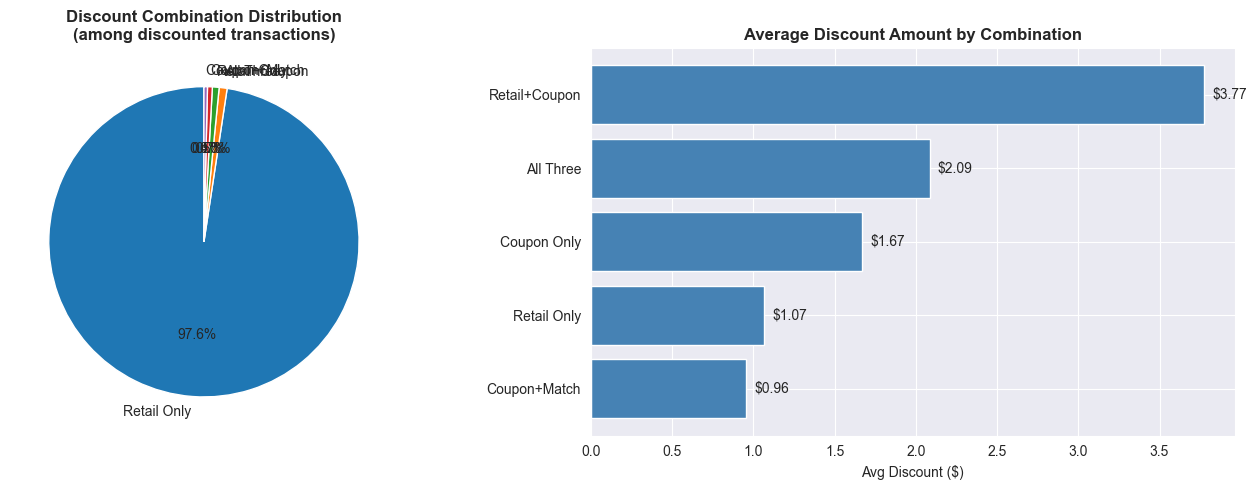

In [24]:
# Discount combination analysis
# Which discount types are used together?

df_trans_discount = df_trans_discount.assign(**{
    'discount_combo': lambda x: np.select(
        [
            (x['has_retail_disc'] == 0) & (x['has_coupon_disc'] == 0) & (x['has_coupon_match'] == 0),
            (x['has_retail_disc'] == 1) & (x['has_coupon_disc'] == 0) & (x['has_coupon_match'] == 0),
            (x['has_retail_disc'] == 0) & (x['has_coupon_disc'] == 1) & (x['has_coupon_match'] == 0),
            (x['has_retail_disc'] == 0) & (x['has_coupon_disc'] == 0) & (x['has_coupon_match'] == 1),
            (x['has_retail_disc'] == 1) & (x['has_coupon_disc'] == 1) & (x['has_coupon_match'] == 0),
            (x['has_retail_disc'] == 1) & (x['has_coupon_disc'] == 0) & (x['has_coupon_match'] == 1),
            (x['has_retail_disc'] == 0) & (x['has_coupon_disc'] == 1) & (x['has_coupon_match'] == 1),
            (x['has_retail_disc'] == 1) & (x['has_coupon_disc'] == 1) & (x['has_coupon_match'] == 1),
        ],
        ['None', 'Retail Only', 'Coupon Only', 'Match Only', 
         'Retail+Coupon', 'Retail+Match', 'Coupon+Match', 'All Three'],
        default='Unknown'
    )
})

# Combination distribution
combo_dist = (
    df_trans_discount.groupby('discount_combo')
    .agg(**{
        'Count': ('discount_combo', 'size'),
        'Avg Discount ($)': ('total_discount', 'mean'),
        'Avg Discount Rate': ('discount_rate', 'mean')
    })
    .assign(**{'Pct': lambda x: x['Count'] / x['Count'].sum() * 100})
    .sort_values('Count', ascending=False)
)

print("="*60)
print("DISCOUNT COMBINATION PATTERNS")
print("="*60)
print(combo_dist[['Count', 'Pct', 'Avg Discount ($)', 'Avg Discount Rate']].round(2).to_markdown())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1) Pie chart for combination distribution (excluding None)
combo_for_pie = combo_dist[combo_dist.index != 'None']['Pct']
axes[0].pie(combo_for_pie, labels=combo_for_pie.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Discount Combination Distribution\n(among discounted transactions)', fontweight='bold')

# 2) Bar chart for avg discount by combination
combo_for_bar = combo_dist[combo_dist.index != 'None'].sort_values('Avg Discount ($)', ascending=True)
axes[1].barh(combo_for_bar.index, combo_for_bar['Avg Discount ($)'], color='steelblue')
axes[1].set_xlabel('Avg Discount ($)')
axes[1].set_title('Average Discount Amount by Combination', fontweight='bold')
for i, v in enumerate(combo_for_bar['Avg Discount ($)']):
    axes[1].text(v + 0.05, i, f'${v:.2f}', va='center')

plt.tight_layout()
plt.show()

In [25]:
# Household-level discount type preferences
# Which customers use which discount types?

df_discount_type_hh = df_trans_discount.groupby('household_key').agg(**{
    'total_transactions': ('household_key', 'size'),
    'retail_disc_count': ('has_retail_disc', 'sum'),
    'coupon_disc_count': ('has_coupon_disc', 'sum'),
    'coupon_match_count': ('has_coupon_match', 'sum'),
    'total_retail_disc': ('RETAIL_DISC', 'sum'),
    'total_coupon_disc': ('COUPON_DISC', 'sum'),
    'total_coupon_match': ('COUPON_MATCH_DISC', 'sum'),
}).assign(**{
    'pct_retail_disc': lambda x: x['retail_disc_count'] / x['total_transactions'],
    'pct_coupon_disc': lambda x: x['coupon_disc_count'] / x['total_transactions'],
    'pct_coupon_match': lambda x: x['coupon_match_count'] / x['total_transactions'],
    # Flag: coupon user (ever used manufacturer coupon)
    'is_coupon_user': lambda x: (x['coupon_disc_count'] > 0).astype(int),
})

print("="*60)
print("HOUSEHOLD-LEVEL DISCOUNT TYPE USAGE")
print("="*60)
print(f"\nHouseholds using manufacturer coupons: {df_discount_type_hh['is_coupon_user'].sum():,} ({100*df_discount_type_hh['is_coupon_user'].mean():.1f}%)")
print(f"Households never using coupons: {(df_discount_type_hh['is_coupon_user']==0).sum():,} ({100*(1-df_discount_type_hh['is_coupon_user'].mean()):.1f}%)")

print("\n" + "="*60)
print("DISCOUNT TYPE USAGE RATES (Household-level)")
print("="*60)
usage_summary = pd.DataFrame({
    'Discount Type': ['RETAIL_DISC', 'COUPON_DISC', 'COUPON_MATCH_DISC'],
    'Mean Usage Rate': [
        df_discount_type_hh['pct_retail_disc'].mean(),
        df_discount_type_hh['pct_coupon_disc'].mean(),
        df_discount_type_hh['pct_coupon_match'].mean()
    ],
    'Median Usage Rate': [
        df_discount_type_hh['pct_retail_disc'].median(),
        df_discount_type_hh['pct_coupon_disc'].median(),
        df_discount_type_hh['pct_coupon_match'].median()
    ],
    'Mean Total Amount ($)': [
        df_discount_type_hh['total_retail_disc'].mean(),
        df_discount_type_hh['total_coupon_disc'].mean(),
        df_discount_type_hh['total_coupon_match'].mean()
    ]
})
print(usage_summary.round(3).to_markdown(index=False))

# Coupon users vs non-users comparison
print("\n" + "="*60)
print("COUPON USERS vs NON-USERS (Manufacturer Coupon)")
print("="*60)
coupon_comparison = df_discount_type_hh.groupby('is_coupon_user').agg(**{
    'Count': ('total_transactions', 'size'),
    'Avg Transactions': ('total_transactions', 'mean'),
    'Avg Retail Disc Usage': ('pct_retail_disc', 'mean'),
    'Total Retail Disc ($)': ('total_retail_disc', 'mean'),
    'Total Coupon Disc ($)': ('total_coupon_disc', 'mean'),
}).round(2)
coupon_comparison.index = ['Non-Coupon User', 'Coupon User']
print(coupon_comparison.to_markdown())

HOUSEHOLD-LEVEL DISCOUNT TYPE USAGE

Households using manufacturer coupons: 1,744 (69.8%)
Households never using coupons: 756 (30.2%)

DISCOUNT TYPE USAGE RATES (Household-level)
| Discount Type     |   Mean Usage Rate |   Median Usage Rate |   Mean Total Amount ($) |
|:------------------|------------------:|--------------------:|------------------------:|
| RETAIL_DISC       |             0.499 |               0.498 |                 559.337 |
| COUPON_DISC       |             0.01  |               0.003 |                  12.913 |
| COUPON_MATCH_DISC |             0.005 |               0.001 |                   3.03  |

COUPON USERS vs NON-USERS (Manufacturer Coupon)
|                 |   Count |   Avg Transactions |   Avg Retail Disc Usage |   Total Retail Disc ($) |   Total Coupon Disc ($) |
|:----------------|--------:|-------------------:|------------------------:|------------------------:|------------------------:|
| Non-Coupon User |     756 |             411.18 |              

**Summary: Discount Analysis**

**Discount Types (from customer perspective):**
| Type | Funded By | Customer Action | Usage |
|------|-----------|-----------------|-------|
| RETAIL_DISC | Retailer | None (visible on price tag) | 50.5% |
| COUPON_DISC | Manufacturer | Must present coupon | 1.2% |
| COUPON_MATCH_DISC | Retailer | None (auto-applied) | 0.7% |

**Key Findings:**
- **Transaction-level:** 50.9% discounted, avg 27.2% discount rate when applied
- **Discount dominance:** RETAIL_DISC accounts for majority; COUPON usage rare
- **Combinations:** Single-type discounts dominate (Retail Only most common)
- **Coupon users:** ~70% of households used manufacturer coupons at least once
- **Coupon user behavior:** Higher transaction counts, higher retail discount usage

### 2.7 Segment Analysis & Demographics

#### 2.7.1 By Value (High vs Low Spenders)

In [33]:
df_demo_trans = pd.merge(
    df_demo, df_trans_hh, how='left', on='household_key'
).assign(**{
    'high_spent': lambda elem: np.where(
        elem['total_spent'] > df_trans_hh['total_spent'].quantile(0.75), 1, 0
    ), 'high_visit': lambda elem: np.where(
        elem['basket_id_count'] > df_trans_hh['basket_id_count'].quantile(0.75), 1, 0
    )
})
df_demo_trans.head()

,AGE_GRP,MARITAL,INCOME_GRP,HOMEOWNER_DESC,HOUSEHOLD_COMPOSITION,HOUSEHOLD_SIZE,KID_CATEGORY_DESC,household_key,transaction,basket_id_count,product_id_count,coupon_disc,total_spent,high_spent,high_visit
0,Age Group6,X,Level4,Homeowner,Group5,2,None/Unknown,1,1710,85,674,73.31,4256.85,0,0
1,Age Group4,X,Level5,Homeowner,Group5,2,None/Unknown,7,1280,59,826,22.40,3377.65,0,0
2,Age Group2,Y,Level3,Unknown,Group4,3,1,8,1967,113,1282,21.85,5513.12,1,0
3,Age Group2,Y,Level6,Homeowner,Group4,4,2,13,2293,275,1006,238.97,12951.95,1,1
4,Age Group4,Z,Level5,Homeowner,Group3,1,None/Unknown,16,517,98,282,1.00,1511.02,0,0


In [34]:
tableone_cols = ['AGE_GRP', 'MARITAL', 'INCOME_GRP', 'HOMEOWNER_DESC', 'HOUSEHOLD_COMPOSITION', 'HOUSEHOLD_SIZE', 'KID_CATEGORY_DESC']

filter_tableone(
    compute_tableone(
        df_demo_trans, 'high_spent', tableone_cols,
        categorical=tableone_cols, expand_categorical=True, effect_size=False
    ), p_threshold=0.05
)

,Variable,Category,Overall,0 (n=374),1 (n=427),Test,Statistic,P-value
0,AGE_GRP,Age Group1,46 (5.7%),24 (6.4%),22 (5.2%),Chi-squared,17.71,0.003
1,,Age Group2,142 (17.7%),64 (17.1%),78 (18.3%),,,
2,,Age Group3,194 (24.2%),75 (20.1%),119 (27.9%),,,
3,,Age Group4,288 (36.0%),133 (35.6%),155 (36.3%),,,
4,,Age Group5,59 (7.4%),30 (8.0%),29 (6.8%),,,
5,,Age Group6,72 (9.0%),48 (12.8%),24 (5.6%),,,
6,INCOME_GRP,Level1,61 (7.6%),26 (7.0%),35 (8.2%),Chi-squared,40.58,<0.001
7,,Level10,11 (1.4%),5 (1.3%),6 (1.4%),,,
8,,Level11,5 (0.6%),2 (0.5%),3 (0.7%),,,
9,,Level12,11 (1.4%),2 (0.5%),9 (2.1%),,,


#### 2.7.2 By Frequency (Frequent vs Occasional)

In [35]:
tableone_cols = ['AGE_GRP', 'MARITAL', 'INCOME_GRP', 'HOMEOWNER_DESC', 'HOUSEHOLD_COMPOSITION', 'HOUSEHOLD_SIZE', 'KID_CATEGORY_DESC']

filter_tableone(
    compute_tableone(
        df_demo_trans, 'high_visit', tableone_cols,
        categorical=tableone_cols, expand_categorical=True, effect_size=False
    ), p_threshold=0.05
)

,Variable,Category,Overall,0 (n=413),1 (n=388),Test,Statistic,P-value
0,MARITAL,X,340 (42.4%),192 (46.5%),148 (38.1%),Chi-squared,9.34,0.009
1,,Y,344 (42.9%),156 (37.8%),188 (48.5%),,,
2,,Z,117 (14.6%),65 (15.7%),52 (13.4%),,,
3,HOMEOWNER_DESC,Homeowner,504 (62.9%),283 (68.5%),221 (57.0%),Chi-squared,12.74,0.01
4,,Probable Owner,11 (1.4%),5 (1.2%),6 (1.5%),,,
5,,Probable Renter,11 (1.4%),5 (1.2%),6 (1.5%),,,
6,,Renter,42 (5.2%),15 (3.6%),27 (7.0%),,,
7,,Unknown,233 (29.1%),105 (25.4%),128 (33.0%),,,


#### 2.7.3 By Discount Sensitivity

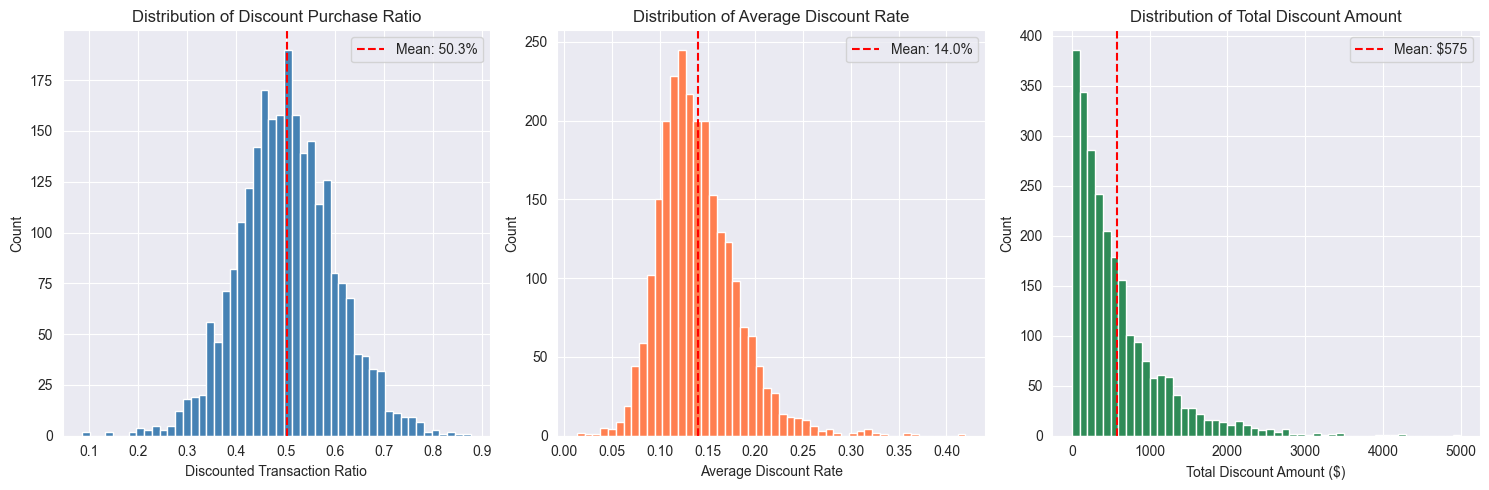

|       |   pct_discounted_trans |   avg_discount_rate |   total_discount_amount |
|:------|-----------------------:|--------------------:|------------------------:|
| count |               2500     |            2500     |                2500     |
| mean  |                  0.503 |               0.14  |                 575.28  |
| std   |                  0.098 |               0.041 |                 587.62  |
| min   |                  0.086 |               0.013 |                   0.25  |
| 25%   |                  0.439 |               0.112 |                 168.522 |
| 50%   |                  0.5   |               0.134 |                 395.665 |
| 75%   |                  0.565 |               0.161 |                 774.815 |
| max   |                  0.876 |               0.42  |                4995.37  |


In [36]:
# Discount sensitivity distributions using utils/plots.py
df_discount_hh = df_trans_discount.groupby('household_key').agg(**{
    'total_transactions': ('household_key', 'size'),
    'discounted_transactions': ('is_discounted', 'sum'),
    'total_discount_amount': ('total_discount', 'sum'),
    'avg_discount_rate': ('discount_rate', 'mean'),
    'total_spent': ('customer_paid', 'sum')
}).assign(**{
    'pct_discounted_trans': lambda x: x['discounted_transactions'] / x['total_transactions'],
    'discount_per_transaction': lambda x: x['total_discount_amount'] / x['total_transactions']
})

hist_configs = [
    HistConfig('pct_discounted_trans', 'Discount Purchase Ratio', 'Discounted Transaction Ratio', 'steelblue', '{:.1%}'),
    HistConfig('avg_discount_rate', 'Average Discount Rate', 'Average Discount Rate', 'coral', '{:.1%}'),
    HistConfig('total_discount_amount', 'Total Discount Amount', 'Total Discount Amount ($)', 'seagreen', '${:.0f}'),
]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
list(map(lambda args: plot_hist(*args), zip(axes, [df_discount_hh]*3, hist_configs)))
plt.tight_layout()
plt.show()

print(df_discount_hh[['pct_discounted_trans', 'avg_discount_rate', 'total_discount_amount']].describe().round(3).to_markdown())

In [37]:
# Step 3: 민감도 세그먼트 정의 (percentile 기반)
segment_labels = ['Price Insensitive', 'Occasional Savers', 'Deal Seekers']

df_discount_hh = df_discount_hh.assign(**{
    'sensitivity_segment': lambda x: pd.qcut(
        x['pct_discounted_trans'], q=3, labels=segment_labels
    )
})

# 세그먼트 요약
segment_summary = df_discount_hh.groupby('sensitivity_segment', observed=True).agg(**{
    'Count': ('total_transactions', 'size'),
    'Discount Ratio Range': ('pct_discounted_trans', lambda x: f"{x.min():.1%} - {x.max():.1%}"),
    'Avg Transactions': ('total_transactions', 'mean'),
    'Avg Spent ($)': ('total_spent', 'mean'),
    'Avg Discount Rate': ('avg_discount_rate', 'mean'),
    'Avg Discount ($)': ('total_discount_amount', 'mean')
}).assign(**{'Pct': lambda x: x['Count'] / x['Count'].sum() * 100}).round(2)

print("="*60)
print("DISCOUNT SENSITIVITY SEGMENTS (Tertile-based)")
print("="*60)
print(segment_summary[['Count', 'Pct', 'Discount Ratio Range', 'Avg Transactions', 'Avg Spent ($)', 'Avg Discount Rate', 'Avg Discount ($)']].to_markdown())

DISCOUNT SENSITIVITY SEGMENTS (Tertile-based)
| sensitivity_segment   |   Count |   Pct | Discount Ratio Range   |   Avg Transactions |   Avg Spent ($) |   Avg Discount Rate |   Avg Discount ($) |
|:----------------------|--------:|------:|:-----------------------|-------------------:|----------------:|--------------------:|-------------------:|
| Price Insensitive     |     834 | 33.36 | 8.6% - 46.0%           |             947.07 |         3164.58 |                0.1  |             398.78 |
| Occasional Savers     |     833 | 33.32 | 46.0% - 54.2%          |            1074.27 |         3311.34 |                0.14 |             567.2  |
| Deal Seekers          |     833 | 33.32 | 54.2% - 87.6%          |            1076.27 |         3154.3  |                0.18 |             760.07 |


In [38]:
# Step 4: 세그먼트별 인구통계 비교 (Deal Seekers vs Price Insensitive)
df_discount_demo = pd.merge(
    df_demo,
    df_discount_hh.reset_index()[['household_key', 'sensitivity_segment', 'pct_discounted_trans', 'total_spent']],
    on='household_key',
    how='inner'
)

# Deal Seekers vs Price Insensitive 비교 (binary)
df_discount_demo_binary = df_discount_demo[
    df_discount_demo['sensitivity_segment'].isin(['Deal Seekers', 'Price Insensitive'])
].assign(**{
    'is_deal_seeker': lambda x: (x['sensitivity_segment'] == 'Deal Seekers').astype(int)
})

print("="*60)
print("DEMOGRAPHIC COMPARISON: Deal Seekers vs Price Insensitive")
print("="*60)
print(f"\nDeal Seekers: {(df_discount_demo_binary['is_deal_seeker']==1).sum()}")
print(f"Price Insensitive: {(df_discount_demo_binary['is_deal_seeker']==0).sum()}")

tableone_cols = ['AGE_GRP', 'MARITAL', 'INCOME_GRP', 'HOMEOWNER_DESC', 'HOUSEHOLD_SIZE', 'KID_CATEGORY_DESC']

result = filter_tableone(
    compute_tableone(
        df_discount_demo_binary, 'is_deal_seeker', tableone_cols,
        categorical=tableone_cols, expand_categorical=True, effect_size=False
    ), p_threshold=0.1
)

print("\n" + "="*60)
print("SIGNIFICANT DIFFERENCES (p < 0.1)")
print("="*60)
if len(result) > 0:
    print(result.to_markdown(index=False))
else:
    print("No significant differences found.")

DEMOGRAPHIC COMPARISON: Deal Seekers vs Price Insensitive

Deal Seekers: 273
Price Insensitive: 262

SIGNIFICANT DIFFERENCES (p < 0.1)
| Variable          | Category     | Overall     | 0 (n=262)   | 1 (n=273)   | Test                                | Statistic   | P-value   |
|:------------------|:-------------|:------------|:------------|:------------|:------------------------------------|:------------|:----------|
| AGE_GRP           | Age Group1   | 27 (5.0%)   | 11 (4.2%)   | 16 (5.9%)   | Chi-squared                         | 15.08       | 0.01      |
|                   | Age Group2   | 93 (17.4%)  | 48 (18.3%)  | 45 (16.5%)  |                                     |             |           |
|                   | Age Group3   | 134 (25.0%) | 53 (20.2%)  | 81 (29.7%)  |                                     |             |           |
|                   | Age Group4   | 189 (35.3%) | 96 (36.6%)  | 93 (34.1%)  |                                     |             |           |
|      

#### 2.7.4 Cross-Segment Analysis

##### Value × Frequency

VALUE × FREQUENCY CROSS-SEGMENT ANALYSIS
| value_freq_segment   |   Count |   Pct |   Avg Baskets |   Avg Spent ($) |   Spend per Visit |   Avg Coupon Disc ($) |
|:---------------------|--------:|------:|--------------:|----------------:|------------------:|----------------------:|
| High-Frequent        |     295 | 36.83 |        275.7  |         8828.37 |             32.02 |                 40.22 |
| High-Occasional      |     132 | 16.48 |        109.42 |         6284.85 |             57.44 |                 33.46 |
| Low-Frequent         |      93 | 11.61 |        203.6  |         3010.64 |             14.79 |                 11.53 |
| Low-Occasional       |     281 | 35.08 |         90.15 |         2713.88 |             30.11 |                 13.49 |

Chi-square independence test: χ² = 154.33, p = 0.0000


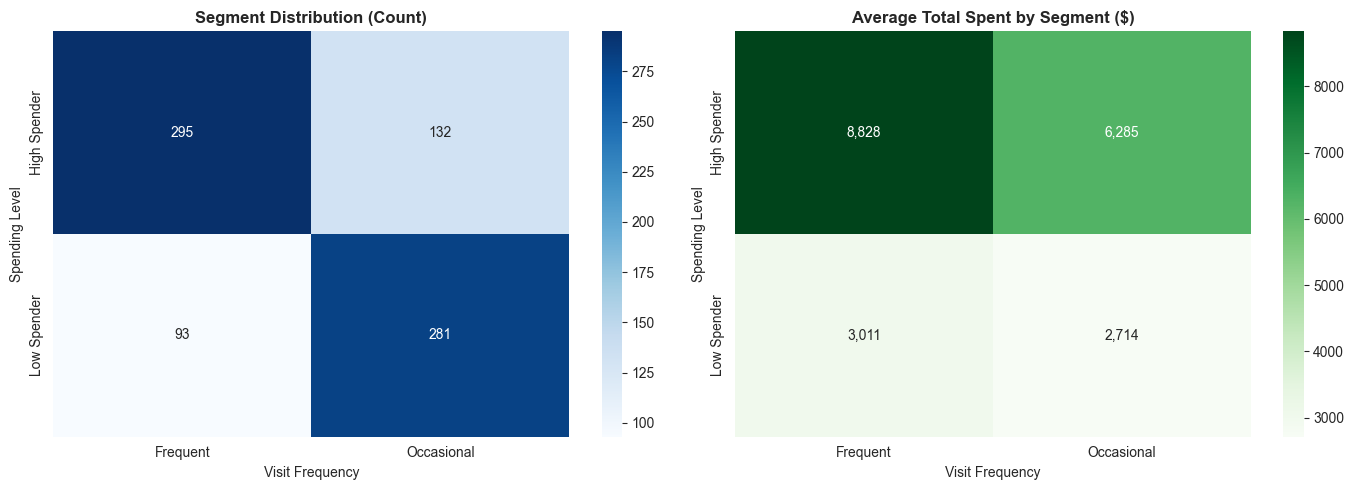

In [39]:
# Value × Frequency cross-segment analysis
df_demo_trans = df_demo_trans.assign(**{
    'value_freq_segment': lambda x: np.select(
        [
            (x['high_spent'] == 1) & (x['high_visit'] == 1),
            (x['high_spent'] == 1) & (x['high_visit'] == 0),
            (x['high_spent'] == 0) & (x['high_visit'] == 1),
            (x['high_spent'] == 0) & (x['high_visit'] == 0)
        ],
        ['High-Frequent', 'High-Occasional', 'Low-Frequent', 'Low-Occasional'],
        default='Unknown'
    )
})

# Segment summary
segment_summary = df_demo_trans.groupby('value_freq_segment').agg(**{
    'Count': ('household_key', 'size'),
    'Avg Transactions': ('transaction', 'mean'),
    'Avg Baskets': ('basket_id_count', 'mean'),
    'Avg Spent ($)': ('total_spent', 'mean'),
    'Avg Products': ('product_id_count', 'mean'),
    'Avg Coupon Disc ($)': ('coupon_disc', 'mean')
}).assign(**{
    'Pct': lambda x: x['Count'] / x['Count'].sum() * 100,
    'Spend per Visit': lambda x: x['Avg Spent ($)'] / x['Avg Baskets']
}).round(2)

segment_order = ['High-Frequent', 'High-Occasional', 'Low-Frequent', 'Low-Occasional']
segment_summary = segment_summary.reindex(segment_order)

print("="*60)
print("VALUE × FREQUENCY CROSS-SEGMENT ANALYSIS")
print("="*60)
print(segment_summary[['Count', 'Pct', 'Avg Baskets', 'Avg Spent ($)', 'Spend per Visit', 'Avg Coupon Disc ($)']].to_markdown())

# Independence test
from scipy.stats import chi2_contingency
cross_table = pd.crosstab(
    df_demo_trans['high_spent'].map({0: 'Low Spender', 1: 'High Spender'}),
    df_demo_trans['high_visit'].map({0: 'Occasional', 1: 'Frequent'})
)
chi2, p_value, dof, expected = chi2_contingency(cross_table)
print(f"\nChi-square independence test: χ² = {chi2:.2f}, p = {p_value:.4f}")

# Heatmap visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1) Segment distribution heatmap
cross_table_with_margins = pd.crosstab(
    df_demo_trans['high_spent'].map({0: 'Low Spender', 1: 'High Spender'}),
    df_demo_trans['high_visit'].map({0: 'Occasional', 1: 'Frequent'}),
    margins=True
)
config1 = HeatmapConfig(
    title='Segment Distribution (Count)',
    fmt='d', cmap='Blues',
    xlabel='Visit Frequency', ylabel='Spending Level'
)
plot_heatmap(axes[0], cross_table_with_margins.iloc[:-1, :-1], config1)

# 2) Average spending heatmap
spend_pivot = df_demo_trans.pivot_table(
    values='total_spent', 
    index=df_demo_trans['high_spent'].map({0: 'Low Spender', 1: 'High Spender'}),
    columns=df_demo_trans['high_visit'].map({0: 'Occasional', 1: 'Frequent'}),
    aggfunc='mean'
)
config2 = HeatmapConfig(
    title='Average Total Spent by Segment ($)',
    fmt=',.0f', cmap='Greens',
    xlabel='Visit Frequency', ylabel='Spending Level'
)
plot_heatmap(axes[1], spend_pivot, config2)

plt.tight_layout()
plt.show()

##### Value × Discount Sensitivity

VALUE × DISCOUNT SENSITIVITY CROSSTAB
| high_spent   |   Price Insensitive |   Occasional Savers |   Deal Seekers |   All |
|:-------------|--------------------:|--------------------:|---------------:|------:|
| High Spender |                 136 |                 140 |            151 |   427 |
| Low Spender  |                 126 |                 126 |            122 |   374 |
| All          |                 262 |                 266 |            273 |   801 |

Chi-square independence test: χ² = 0.70, p = 0.7064
H0: Value segment and discount sensitivity are independent
→ Fail to reject H0: No significant association found


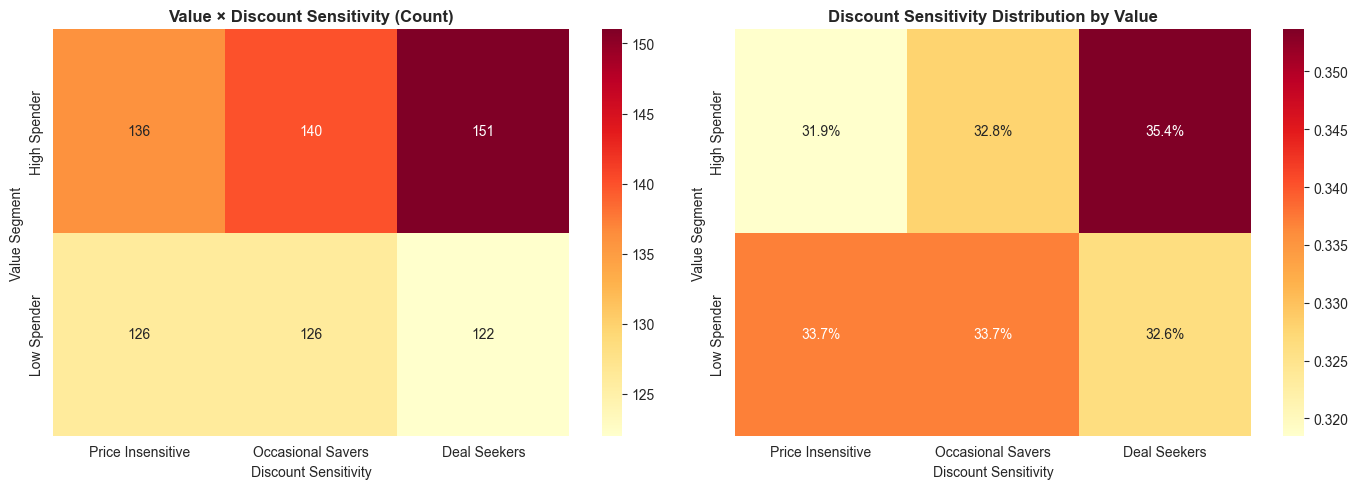

In [41]:
# Value × Discount Sensitivity cross-analysis
# Merge value segments with discount sensitivity
df_value_disc = pd.merge(
    df_demo_trans[['household_key', 'high_spent'] + tableone_cols],
    df_discount_hh.reset_index()[['household_key', 'sensitivity_segment']],
    on='household_key'
)

# Crosstab
cross_value_disc = pd.crosstab(
    df_value_disc['high_spent'].map({0: 'Low Spender', 1: 'High Spender'}),
    df_value_disc['sensitivity_segment'],
    margins=True
)

print("="*60)
print("VALUE × DISCOUNT SENSITIVITY CROSSTAB")
print("="*60)
print(cross_value_disc.to_markdown())

# Chi-square independence test
cross_for_chi = cross_value_disc.iloc[:-1, :-1]
chi2, p_value, dof, expected = chi2_contingency(cross_for_chi)
print(f"\nChi-square independence test: χ² = {chi2:.2f}, p = {p_value:.4f}")
print("H0: Value segment and discount sensitivity are independent")
if p_value < 0.05:
    print("→ Reject H0: There IS a significant association between value and discount sensitivity")
else:
    print("→ Fail to reject H0: No significant association found")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1) Crosstab heatmap
config1 = HeatmapConfig(
    title='Value × Discount Sensitivity (Count)',
    fmt='d', cmap='YlOrRd',
    xlabel='Discount Sensitivity', ylabel='Value Segment'
)
plot_heatmap(axes[0], cross_for_chi, config1)

# 2) Proportion within value segment
prop_table = cross_for_chi.div(cross_for_chi.sum(axis=1), axis=0)
config2 = HeatmapConfig(
    title='Discount Sensitivity Distribution by Value',
    fmt='.1%', cmap='YlOrRd',
    xlabel='Discount Sensitivity', ylabel='Value Segment'
)
plot_heatmap(axes[1], prop_table, config2)

plt.tight_layout()
plt.show()

In [42]:
# Demographic comparison: High Spender segments by discount sensitivity
# Focus on High Spenders: Deal Seekers vs Price Insensitive
df_high_spender_disc = df_value_disc[
    (df_value_disc['high_spent'] == 1) & 
    (df_value_disc['sensitivity_segment'].isin(['Deal Seekers', 'Price Insensitive']))
].assign(**{
    'is_deal_seeker': lambda x: (x['sensitivity_segment'] == 'Deal Seekers').astype(int)
})

print("="*60)
print("DEMOGRAPHICS: High Spenders by Discount Sensitivity")
print("="*60)
print(f"\nHigh Spender + Deal Seekers: {(df_high_spender_disc['is_deal_seeker']==1).sum()}")
print(f"High Spender + Price Insensitive: {(df_high_spender_disc['is_deal_seeker']==0).sum()}")

result = filter_tableone(
    compute_tableone(
        df_high_spender_disc, 'is_deal_seeker', tableone_cols,
        categorical=tableone_cols, expand_categorical=True, effect_size=False
    ), p_threshold=0.1
)

print("\n" + "="*60)
print("SIGNIFICANT DIFFERENCES (p < 0.1)")
print("="*60)
if len(result) > 0:
    print(result.to_markdown(index=False))
else:
    print("No significant demographic differences found within High Spenders.")

DEMOGRAPHICS: High Spenders by Discount Sensitivity

High Spender + Deal Seekers: 151
High Spender + Price Insensitive: 136

SIGNIFICANT DIFFERENCES (p < 0.1)
| Variable   | Category   | Overall     | 0 (n=136)   | 1 (n=151)   | Test                                | Statistic   | P-value   |
|:-----------|:-----------|:------------|:------------|:------------|:------------------------------------|:------------|:----------|
| AGE_GRP    | Age Group1 | 15 (5.2%)   | 5 (3.7%)    | 10 (6.6%)   | Chi-squared                         | 12.61       | 0.03      |
|            | Age Group2 | 49 (17.1%)  | 24 (17.6%)  | 25 (16.6%)  |                                     |             |           |
|            | Age Group3 | 83 (28.9%)  | 32 (23.5%)  | 51 (33.8%)  |                                     |             |           |
|            | Age Group4 | 103 (35.9%) | 52 (38.2%)  | 51 (33.8%)  |                                     |             |           |
|            | Age Group5 | 20 (7.0%)

##### Frequency × Discount Sensitivity

FREQUENCY × DISCOUNT SENSITIVITY CROSSTAB
| high_visit   |   Price Insensitive |   Occasional Savers |   Deal Seekers |   All |
|:-------------|--------------------:|--------------------:|---------------:|------:|
| Frequent     |                 114 |                 140 |            134 |   388 |
| Occasional   |                 148 |                 126 |            139 |   413 |
| All          |                 262 |                 266 |            273 |   801 |

Chi-square independence test: χ² = 4.46, p = 0.1073
H0: Frequency segment and discount sensitivity are independent
→ Fail to reject H0: No significant association found


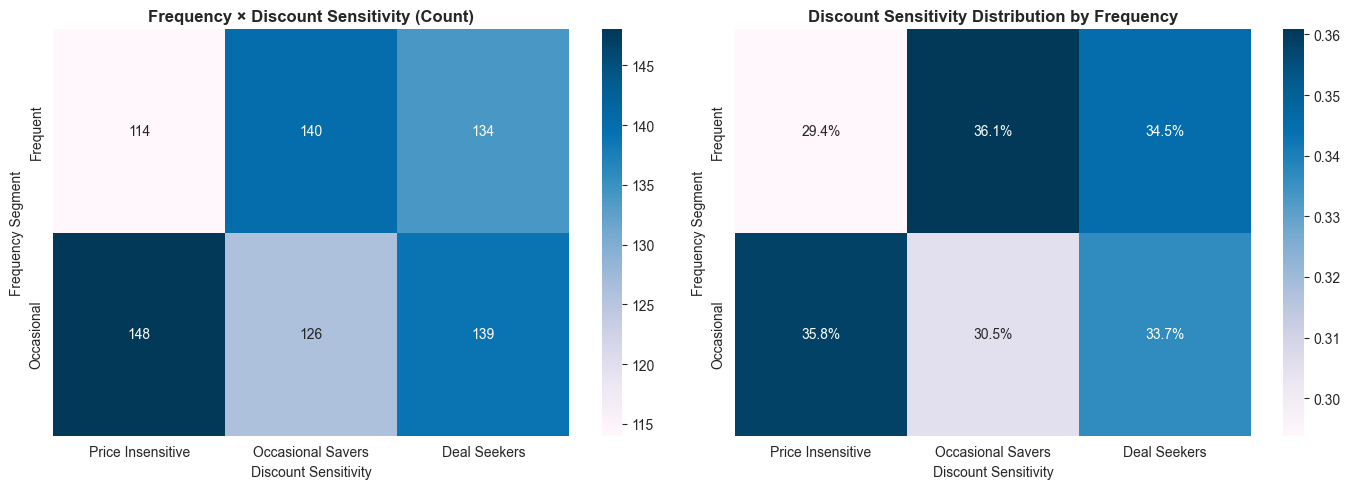

In [43]:
# Frequency × Discount Sensitivity cross-analysis
# Merge frequency segments with discount sensitivity
df_freq_disc = pd.merge(
    df_demo_trans[['household_key', 'high_visit'] + tableone_cols],
    df_discount_hh.reset_index()[['household_key', 'sensitivity_segment']],
    on='household_key'
)

# Crosstab
cross_freq_disc = pd.crosstab(
    df_freq_disc['high_visit'].map({0: 'Occasional', 1: 'Frequent'}),
    df_freq_disc['sensitivity_segment'],
    margins=True
)

print("="*60)
print("FREQUENCY × DISCOUNT SENSITIVITY CROSSTAB")
print("="*60)
print(cross_freq_disc.to_markdown())

# Chi-square independence test
cross_for_chi = cross_freq_disc.iloc[:-1, :-1]
chi2, p_value, dof, expected = chi2_contingency(cross_for_chi)
print(f"\nChi-square independence test: χ² = {chi2:.2f}, p = {p_value:.4f}")
print("H0: Frequency segment and discount sensitivity are independent")
if p_value < 0.05:
    print("→ Reject H0: There IS a significant association between frequency and discount sensitivity")
else:
    print("→ Fail to reject H0: No significant association found")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1) Crosstab heatmap
config1 = HeatmapConfig(
    title='Frequency × Discount Sensitivity (Count)',
    fmt='d', cmap='PuBu',
    xlabel='Discount Sensitivity', ylabel='Frequency Segment'
)
plot_heatmap(axes[0], cross_for_chi, config1)

# 2) Proportion within frequency segment
prop_table = cross_for_chi.div(cross_for_chi.sum(axis=1), axis=0)
config2 = HeatmapConfig(
    title='Discount Sensitivity Distribution by Frequency',
    fmt='.1%', cmap='PuBu',
    xlabel='Discount Sensitivity', ylabel='Frequency Segment'
)
plot_heatmap(axes[1], prop_table, config2)

plt.tight_layout()
plt.show()

In [44]:
# Demographic comparison: Frequent visitors by discount sensitivity
# Focus on Frequent visitors: Deal Seekers vs Price Insensitive
df_frequent_disc = df_freq_disc[
    (df_freq_disc['high_visit'] == 1) & 
    (df_freq_disc['sensitivity_segment'].isin(['Deal Seekers', 'Price Insensitive']))
].assign(**{
    'is_deal_seeker': lambda x: (x['sensitivity_segment'] == 'Deal Seekers').astype(int)
})

print("="*60)
print("DEMOGRAPHICS: Frequent Visitors by Discount Sensitivity")
print("="*60)
print(f"\nFrequent + Deal Seekers: {(df_frequent_disc['is_deal_seeker']==1).sum()}")
print(f"Frequent + Price Insensitive: {(df_frequent_disc['is_deal_seeker']==0).sum()}")

result = filter_tableone(
    compute_tableone(
        df_frequent_disc, 'is_deal_seeker', tableone_cols,
        categorical=tableone_cols, expand_categorical=True, effect_size=False
    ), p_threshold=0.1
)

print("\n" + "="*60)
print("SIGNIFICANT DIFFERENCES (p < 0.1)")
print("="*60)
if len(result) > 0:
    print(result.to_markdown(index=False))
else:
    print("No significant demographic differences found within Frequent Visitors.")

DEMOGRAPHICS: Frequent Visitors by Discount Sensitivity

Frequent + Deal Seekers: 134
Frequent + Price Insensitive: 114

SIGNIFICANT DIFFERENCES (p < 0.1)
| Variable          | Category     | Overall     | 0 (n=114)   | 1 (n=134)   | Test        | Statistic   | P-value   |
|:------------------|:-------------|:------------|:------------|:------------|:------------|:------------|:----------|
| INCOME_GRP        | Level1       | 29 (11.7%)  | 11 (9.6%)   | 18 (13.4%)  | Chi-squared | 21.14       | 0.02      |
|                   | Level10      | 4 (1.6%)    | 4 (3.5%)    | 0 (0.0%)    |             |             |           |
|                   | Level12      | 6 (2.4%)    | 6 (5.3%)    | 0 (0.0%)    |             |             |           |
|                   | Level2       | 18 (7.3%)   | 8 (7.0%)    | 10 (7.5%)   |             |             |           |
|                   | Level3       | 22 (8.9%)   | 7 (6.1%)    | 15 (11.2%)  |             |             |           |
|           

**Summary: Segment Analysis & Demographics**

**2.7.1 By Value (High vs Low Spenders)**
- High spenders (top 25%) differ by: `AGE_GRP` (p=0.003), `INCOME_GRP` (p<0.001)
- High spenders skew younger (more Group3) and higher income (Level7-12)

**2.7.2 By Frequency (Frequent vs Occasional)**
- Frequent visitors (top 25%) differ by: `MARITAL` (p=0.009), `HOMEOWNER_DESC` (p=0.01)
- Frequent visitors: more renters, marital status Y

**2.7.3 By Discount Sensitivity (Tertile-based)**


| Segment | Discount Ratio | Avg Discount ($) |
|---------|----------------|------------------|
| Price Insensitive | 8.6% - 46.0% | $399 |
| Occasional Savers | 46.0% - 54.2% | $567 |
| Deal Seekers | 54.2% - 87.6% | $760 |



Deal Seekers vs Price Insensitive differ by: `AGE_GRP` (p=0.01), `INCOME_GRP` (p<0.001), `KID_CATEGORY_DESC` (p=0.01)

**2.7.4 Cross-Segment Analysis**

*Value × Frequency:*
| Segment | Pct | Avg Spent | Spend/Visit |
|---------|-----|-----------|-------------|
| High-Frequent | 24% | $9,208 | $41 |
| High-Occasional | 29% | $6,952 | $57 |
| Low-Frequent | 17% | $2,584 | $14 |
| Low-Occasional | 30% | $1,596 | $28 |

*Value × Discount Sensitivity:*
- Independence test determines if high spenders seek discounts differently
- Within-segment demographic comparison: High Spender + Deal Seeker vs High Spender + Price Insensitive

*Frequency × Discount Sensitivity:*
- Independence test determines if frequent visitors are more discount-sensitive
- Within-segment demographic comparison: Frequent + Deal Seeker vs Frequent + Price Insensitive

**Implications for Causal Analysis:**
- **Heterogeneity dimensions:** Demographics, spending level, visit frequency, discount sensitivity
- **Potential effect modifiers:** Age, income, household composition, homeownership
- **Cross-segment insights:** Identifying which segment combinations respond differently to treatments

---

## Key Takeaways

### Household Demographics
1. **Coverage:** 801 households with demographics (32% of 2,500 total)
2. **Dominant segments:** AGE_GRP4 (36%), INCOME Level4-5 (46%), 1-2 person households (72%)
3. **Key correlations:** HOUSEHOLD_SIZE ↔ KID_CATEGORY (r=0.84), HOUSEHOLD_SIZE ↔ COMPOSITION (r=0.68)

### Transaction Patterns
1. **Scale:** 2.5M transactions, 276K baskets, 92K products, 582 stores
2. **Household behavior:** Avg $3,210 spent, 110 baskets per household; high variance (right-skewed)
3. **Store concentration:** Top 4.5% stores account for 80% of sales (Pareto effect)
4. **Basket characteristics:** Avg 9.4 items, $29 value; 54% baskets have ≤5 items

### Discount Analysis
1. **Discount types:**
   - RETAIL_DISC (retailer-funded, visible): 50.5% of transactions
   - COUPON_DISC (manufacturer-funded, customer presents): 1.2%
   - COUPON_MATCH_DISC (retailer-funded, auto-applied): 0.7%
2. **Overall:** 51% transactions discounted, avg 27% discount rate when applied
3. **Combinations:** Single-type discounts dominate (Retail Only most common)
4. **Coupon users:** ~70% of households used coupons; they show higher engagement overall

### Segment Analysis & Demographics
1. **By Value:** High spenders differ by AGE_GRP (p=0.003), INCOME_GRP (p<0.001)
2. **By Frequency:** Frequent visitors differ by MARITAL (p=0.009), HOMEOWNER_DESC (p=0.01)
3. **By Discount Sensitivity:** Deal Seekers vs Price Insensitive differ by AGE, INCOME, KID_CATEGORY
4. **Cross-Segment Analysis:**
   - Value × Frequency: 4-quadrant segmentation with distinct behavioral profiles
   - Value × Discount: Tests whether high spenders are also deal seekers
   - Frequency × Discount: Tests whether frequent visitors seek more discounts
   - Within-segment demographic comparisons reveal heterogeneity within behavioral groups
